- build application
- test it manually
- use ragas to calculate a score
- make an improvement
- recompute score

In [14]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext,OpenAIEmbedding
from langchain.embeddings import HuggingFaceEmbeddings

import pandas as pd

def build_query_engine(embed_model):
    vector_index = VectorStoreIndex.from_documents(
        documents, service_context=ServiceContext.from_defaults(chunk_size=512),
        embed_model=embed_model,
    )
    
    
    query_engine = vector_index.as_query_engine(similarity_top_k=2)
    return query_engine

# Build an LLM Application

In [2]:
from llama_index import download_loader

SemanticScholarReader = download_loader("SemanticScholarReader")
loader = SemanticScholarReader()

query_space = "large language models"
documents = loader.load_data(query=query_space, limit=100)

In [7]:
openai_model = OpenAIEmbedding()
vector_index = VectorStoreIndex.from_documents(
    documents, 
    service_context=ServiceContext.from_defaults(chunk_size=512),
    embed_model=openai_model,
)
vector_index.storage_context.persist("openai")

# Test it Manually

In [ ]:
!llamachat openai

# Test with Ragas

1. Build a test dataset
2. Evaluate with Ragas Metrics

In [44]:
from ragas.testset import TestsetGenerator

testsetgenerator = TestsetGenerator.from_default()
test_size = 50  # Number of samples to generate
testset = testsetgenerator.generate(documents, test_size=test_size)





  0%|                                                                   | 0/50 [00:00<?, ?it/s]



  2%|█▏                                                         | 1/50 [00:16<13:30, 16.54s/it]



  6%|███▌                                                       | 3/50 [00:34<08:29, 10.83s/it]



 12%|███████                                                    | 6/50 [00:42<04:20,  5.93s/it]



 20%|███████████▌                                              | 10/50 [00:52<02:43,  4.09s/it]



 30%|█████████████████▍                                        | 15/50 [00:58<01:30,  2.59s/it]



 42%|████████████████████████▎                                 | 21/50 [01:04<00:54,  1.89s/it]



 56%|████████████████████████████████▍                         | 28/50 [01:18<00:42,  1.94s/it]



 72%|█████████████████████████████████████████▊                | 36/50 [01:42<00:33,  2.38s/it]



 90%|████████████████████████████████████████████████████▏     | 45/50 [01:52<00:09,  1.87s/it]



55it [

SyntaxError: unterminated string literal (detected at line 1) (<string>, line 1)

In [42]:
test_df = testset.to_pandas()
test_df.head()

,question,context,answer,question_type,episode_done
0,What is the purpose of self-verification in la...,Large Language Models are reasoners with Self-...,The purpose of self-verification in large lang...,simple,True
1,What is the proposed approach for fact-checkin...,- Existing fact-checking approaches either req...,The proposed approach for fact-checking respon...,simple,True
2,What is the proposed method for automatic inst...,"- ""We propose Automatic Prompt Engineer (APE) ...",The proposed method for automatic instruction ...,simple,True
3,How does the use of large language models for ...,- We prompt the large language model with a se...,The use of large language models for few-shot ...,reasoning,True
4,What is the performance of the largest fine-tu...,"On the MathQA-Python dataset, the largest fine...",The performance of the largest fine-tuned mode...,simple,True


In [43]:
len(test_df)

31

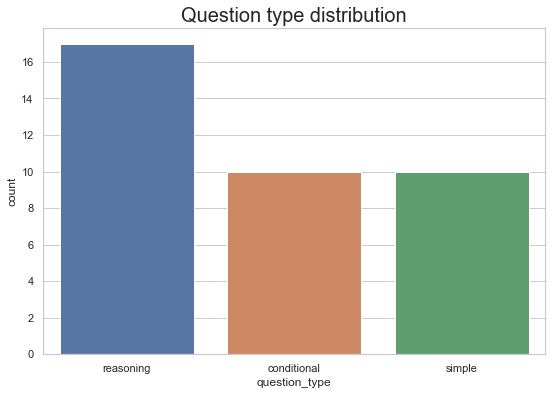

In [32]:
# evaluate with ragas
from ragas.llama_index import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
)
from ragas.llama_index import evaluate

metrics = [
    context_precision,
    context_recall,
]

test_questions = test_df['question'].values.tolist()
test_answers = [[item] for item in test_df['answer'].values.tolist()]

result = evaluate(qe1, metrics, test_questions, test_answers)

evaluating with [context_precision]





  0%|                                                                    | 0/3 [00:00<?, ?it/s]


 33%|████████████████████                                        | 1/3 [01:07<02:14, 67.48s/it]


 67%|████████████████████████████████████████                    | 2/3 [02:06<01:02, 62.24s/it]


100%|████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.30s/it]


evaluating with [context_recall]





  0%|                                                                    | 0/3 [00:00<?, ?it/s]


 33%|████████████████████                                        | 1/3 [01:07<02:14, 67.19s/it]


 67%|████████████████████████████████████████                    | 2/3 [02:16<01:08, 68.15s/it]


100%|████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 46.00s/it]


In [33]:
openai_result = result
openai_result

{'ragas_score': 0.4406, 'context_precision': 0.3372, 'context_recall': 0.6355}

In [34]:
openai_result_df = openai_result.to_pandas()
openai_result_df.head()

,question,contexts,answer,ground_truths,context_precision,context_recall
0,What is the purpose of self-verification in la...,[Large Language Models are reasoners with Self...,\nThe purpose of self-verification in large la...,[The purpose of self-verification in large lan...,0.312500,0.666667
1,What is the proposed approach for fact-checkin...,[the fluency and informativeness of its respon...,\nThe proposed approach for fact-checking resp...,[The proposed approach for fact-checking respo...,0.400000,0.000000
2,What is the proposed method for automatic inst...,[Automatic Generation of Programming Exercises...,\nThe proposed method for automatic instructio...,[The proposed method for automatic instruction...,0.000000,0.000000
3,How does the use of large language models for ...,[TabLLM: Few-shot Classification of Tabular Da...,\nThe use of large language models for few-sho...,[The use of large language models for few-shot...,0.500000,1.000000
4,What is the performance of the largest fine-tu...,[Program Synthesis with Large Language Models ...,\nThe performance of the largest fine-tuned mo...,[The performance of the largest fine-tuned mod...,0.083333,1.000000


# Make Improvements

In [35]:
flag_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
query_engine2 = build_query_engine(flag_model)
result = evaluate(query_engine2, metrics, test_questions, test_answers)

evaluating with [context_precision]





  0%|                                                                    | 0/3 [00:00<?, ?it/s]


 33%|████████████████████                                        | 1/3 [01:09<02:19, 69.81s/it]


 67%|████████████████████████████████████████                    | 2/3 [02:01<00:59, 59.19s/it]


100%|████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.43s/it]


evaluating with [context_recall]





  0%|                                                                    | 0/3 [00:00<?, ?it/s]


 33%|████████████████████                                        | 1/3 [01:05<02:11, 65.83s/it]


 67%|████████████████████████████████████████                    | 2/3 [02:17<01:09, 69.20s/it]


100%|████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.47s/it]


In [36]:
hf_result = result
hf_result

{'ragas_score': 0.4392, 'context_precision': 0.3321, 'context_recall': 0.6484}

In [37]:
hf_result_df = hf_result.to_pandas()
hf_result_df.head()

,question,contexts,answer,ground_truths,context_precision,context_recall
0,What is the purpose of self-verification in la...,[Large Language Models are reasoners with Self...,\nThe purpose of self-verification in large la...,[The purpose of self-verification in large lan...,0.500000,0.666667
1,What is the proposed approach for fact-checkin...,[the fluency and informativeness of its respon...,\nThe proposed approach for fact-checking resp...,[The proposed approach for fact-checking respo...,0.500000,0.000000
2,What is the proposed method for automatic inst...,[Automatic Generation of Programming Exercises...,\nThe proposed method for automatic instructio...,[The proposed method for automatic instruction...,0.000000,0.000000
3,How does the use of large language models for ...,[TabLLM: Few-shot Classification of Tabular Da...,\nThe use of large language models for few-sho...,[The use of large language models for few-shot...,0.416667,1.000000
4,What is the performance of the largest fine-tu...,[Program Synthesis with Large Language Models ...,\nThe performance of the largest fine-tuned mo...,[The performance of the largest fine-tuned mod...,0.083333,1.000000


In [38]:
hf_result_df["context_recall"] - openai_result_df["context_recall"] 

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.4
29    0.0
30    0.0
Name: context_recall, dtype: float64

In [27]:
openai_result_df.iloc[6]

question             In what ways can language models enhance robot...
contexts             [ProgPrompt: Generating Situated Robot Task Pl...
answer               \nLanguage models can enhance robot task plann...
ground_truths        [Language models can enhance robot task planni...
context_precision                                                  0.5
context_recall                                                     1.0
Name: 6, dtype: object

In [28]:
hf_result_df.iloc[6]

question             In what ways can language models enhance robot...
contexts             [ProgPrompt: Generating Situated Robot Task Pl...
answer               \nLanguage models can enhance robot task plann...
ground_truths        [Language models can enhance robot task planni...
context_precision                                             0.285714
context_recall                                                0.333333
Name: 6, dtype: object